<a href="https://colab.research.google.com/github/2000siddharth/TaxiFarePrediction/blob/master/RandomForestsTaxi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
df = pd.read_csv('train_file.csv', index_col=0)
df.drop('color', inplace=True, axis=1)
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,weekday,fare-bin,haversine
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,17,0,"(0.0, 5.0]",1.031896
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,16,1,"(15.0, 20.0]",8.459418
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,0,3,"(5.0, 10.0]",1.391052
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,4,5,"(5.0, 10.0]",2.802346
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,7,1,"(5.0, 10.0]",2.001353


In [6]:
df['haversine_sq'] = np.power(df['haversine'], 2)
df['log_year'] = np.log10(df['year'])
df['log_dist'] = np.log10(df['haversine']+0.01)
df['log_dist2'] = np.log2(df['haversine']+0.01)

In [7]:
# Absolute difference in latitude and longitude
df['abs_lat_diff'] = (df['dropoff_latitude'] - df['pickup_latitude']).abs()
df['abs_lon_diff'] = (df['dropoff_longitude'] - df['pickup_longitude']).abs()

### First let us start with a simple random forest model with default params and check it's performance.
### We shall start with considering only a subset of features 

In [8]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(df, np.array(df['fare_amount']), 
                                                      stratify = df['fare-bin'], test_size=0.3, 
                                                      random_state = 10)

In [9]:
# Create the random forest
random_forest = RandomForestRegressor(n_estimators = 20, 
                                      max_features = None, oob_score = True, 
                                      bootstrap = True, verbose = 1, n_jobs = -1)

# Train on data
random_forest.fit(X_train[['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count']], y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    5.4s finished
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=None, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=20, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=1, warm_start=False)

In [10]:
y_pred = random_forest.predict(X_test[['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count']])

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished


In [14]:
def scorer(y_true, y_pred, p):
  print('Root-Mean-Squared Error is: ', np.sqrt(mean_squared_error(y_true, y_pred)))
  print('Mean Absolute Error is: ', (mean_absolute_error(y_true, y_pred)))
  print('Mean Standard Error is: ', np.sqrt(mean_squared_error(y_true, y_pred)/(len(y_true) - p - 1)))
  R2 = r2_score(y_true, y_pred)
  print('R2 error is : ', R2)
  adj_r2 = (1 - (1-R2)*(len(y_true)-1)/(len(y_true)-p-1))
  print('Adjusted R2 score is: ', adj_r2)

In [15]:
scorer(y_test, y_pred, 4)

Root-Mean-Squared Error is:  5.173609712512935
Mean Absolute Error is:  2.5035886112151275
Mean Standard Error is:  0.030189538734906655
R2 error is :  0.7121172704920854
Adjusted R2 score is:  0.7120780600958027


In [16]:
y_pred_train = random_forest.predict(X_train[['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count']])
scorer(y_train, y_pred_train, 4)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


Root-Mean-Squared Error is:  2.554734872444528
Mean Absolute Error is:  1.024148279005136
Mean Standard Error is:  0.009759003422294424
R2 error is :  0.9307429431678391
Adjusted R2 score is:  0.9307389007305514


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.4s finished


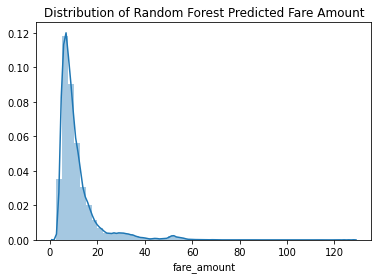

In [18]:
sub = pd.DataFrame({'fare_amount': y_pred})
sub.to_csv('sub_rf_simple.csv', index = False)

sns.distplot(sub['fare_amount'])
plt.title('Distribution of Random Forest Predicted Fare Amount');

In [17]:
# The huge difference in R2 scores clearly show that our model is overfitting on the train data, possible solutions might involve:
# a. Tuning the hyperparameters
# b. Adding more data
# We shall do the former process of tuning our hyperparameters

In [19]:
# using all the features
X_train.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day', 'hour', 'weekday', 'fare-bin', 'haversine',
       'haversine_sq', 'log_year', 'log_dist', 'log_dist2', 'abs_lat_diff',
       'abs_lon_diff'],
      dtype='object')

In [20]:
features = ['pickup_longitude', 'pickup_latitude',
           'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
           'month', 'day', 'hour', 'weekday', 'haversine', 'abs_lat_diff', 'abs_lon_diff']

# Create the random forest
random_forest = RandomForestRegressor(n_estimators = 100, max_depth= 10,
                                      max_features = None, oob_score = True, 
                                      bootstrap = True, verbose = 1, n_jobs = -1)

# Train on data
random_forest.fit(X_train[features], y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   34.9s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features=None, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=1, warm_start=False)

In [22]:
y_pred = random_forest.predict(X_test[features])
y_pred_train = random_forest.predict(X_train[features])

print('\nResults on Training data: ')
scorer(y_train, y_pred_train, len(features))
print('\n')
print('Results on Test data: ')
scorer(y_test, y_pred, len(features))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s



Results on Training data: 
Root-Mean-Squared Error is:  3.248047412037214
Mean Absolute Error is:  1.7944018529127392
Mean Standard Error is:  0.012408249394590785
R2 error is :  0.888051809182628
Adjusted R2 score is:  0.8880305700518415


Results on Test data: 
Root-Mean-Squared Error is:  4.1513132276114995
Mean Absolute Error is:  1.9540996892171048
Mean Standard Error is:  0.024227849867694835
R2 error is :  0.814647139913615
Adjusted R2 score is:  0.8145650667101298


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.4s finished


In [23]:
# After training on all the features, we see that the overfitting has decreased considerably, 
# now let's plot the feature importances for this model

In [31]:
feature_importances

,importance
feature,
haversine,0.805864
abs_lon_diff,0.046655
dropoff_longitude,0.040879
year,0.024464
pickup_longitude,0.020141
dropoff_latitude,0.017583
abs_lat_diff,0.014436
pickup_latitude,0.010073
hour,0.007084


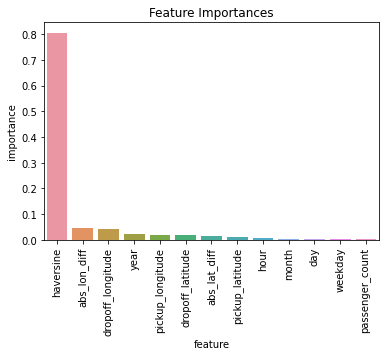

In [33]:
# Extract feature importances
feature_importances = pd.DataFrame({'feature': features,
                                  'importance': random_forest.feature_importances_}).\
                                   sort_values('importance', ascending = False).set_index('feature')

#feature_importances.plot.bar(color = 'b', edgecolor = 'k', linewidth = 2);
sns.barplot(x =feature_importances.index ,y='importance', data=feature_importances)
plt.xticks(rotation=90)
plt.title('Feature Importances');

In [36]:
# Now let's try some hyperparameter tuning. This will help us reduce overfitting to a higher extent.

from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
param_grid = {
    'n_estimators': [200, 250, 300, 400],
    'max_depth': [15, 18, 21, 24],
    'max_features': ['auto', 'sqrt'],
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True]
}

# Estimator for use in random search
estimator = RandomForestRegressor(random_state = 10)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'neg_mean_absolute_error', cv = 3, 
                        n_iter = 100, verbose = 1, random_state=10)

In [ ]:
rs.fit(X_train[features], y_train)

In [42]:
model = RandomForestRegressor(bootstrap=True, criterion='mse',
                      max_depth=20, max_features= 8, max_leaf_nodes=50,
                      min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=1, warm_start=False)

model.fit(X_train[features], y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   49.9s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=8, max_leaf_nodes=50,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=1, warm_start=False)

In [43]:
y_pred = model.predict(X_test[features])
y_pred_train = model.predict(X_train[features])

print('\nResults on Training data: ')
scorer(y_train, y_pred_train, len(features))
print('\n')
print('Results on Test data: ')
scorer(y_test, y_pred, len(features))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s



Results on Training data: 
Root-Mean-Squared Error is:  4.048463479402662
Mean Absolute Error is:  2.077576675635124
Mean Standard Error is:  0.015466013313461273
R2 error is :  0.8260786847107366
Adjusted R2 score is:  0.8260456878616136


Results on Test data: 
Root-Mean-Squared Error is:  4.228639261440388
Mean Absolute Error is:  2.0847344885066974
Mean Standard Error is:  0.024679139239455514
R2 error is :  0.8076777369339161
Adjusted R2 score is:  0.8075925777180075


[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:    0.7s finished


In [44]:
#This hyperparameter tuning process has lead to a significant drop in our overfitting.

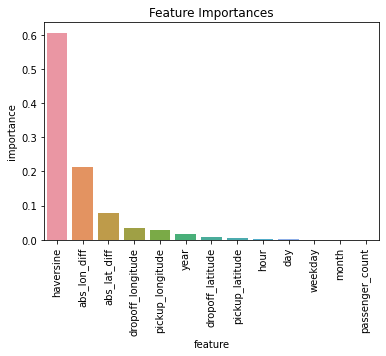

In [45]:
# Extract feature importances
feature_importances = pd.DataFrame({'feature': features,
                                  'importance': model.feature_importances_}).\
                                   sort_values('importance', ascending = False).set_index('feature')

#feature_importances.plot.bar(color = 'b', edgecolor = 'k', linewidth = 2);
sns.barplot(x =feature_importances.index ,y='importance', data=feature_importances)
plt.xticks(rotation=90)
plt.title('Feature Importances');

##### With this we have come to the end of our regression process using Random Forests for our dataset.
##### As expected, the 'haversine' distance was the most important feature for our model built using the dataset we have.

### Key Takeways :
#### 1. On including all the features and after some hyperparam tuning we were able to minimise overfitting in our model.
#### 2. The model gave the highest importance to the distance metric used - 'haversine' distance.
#### 3. It also seems that the dropoff and pickup longitude are more important than the corresponding latitudes.
#### 4. I think that with more data and some efficient feature engineering we can get a higher improvement in accuracy of regression.
#### 5. Efficient methods like 'Adaboost' and 'XGBoost' can be used to get better performing and more accurate models